In [ ]:
#export 
from fastai2.basics import *
from fastai2.vision.all import *

In [ ]:
#default_exp vision.gan
#default_cls_lvl 3

In [ ]:
#hide
from nbdev.showdoc import *

# GAN

> Basic support for [Generative Adversial Networks](https://arxiv.org/abs/1406.2661)

GAN stands for [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf) and were invented by Ian Goodfellow. The concept is that we train two models at the same time: a generator and a critic. The generator will try to make new images similar to the ones in a dataset, and the critic will try to classify real images from the ones the generator does. The generator returns images, the critic a single number (usually a probability, 0. for fake images and 1. for real ones).

We train them against each other in the sense that at each step (more or less), we:
1. Freeze the generator and train the critic for one step by:
  - getting one batch of true images (let's call that `real`)
  - generating one batch of fake images (let's call that `fake`)
  - have the critic evaluate each batch and compute a loss function from that; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the critic with the gradients of this loss
  
  
2. Freeze the critic and train the generator for one step by:
  - generating one batch of fake images
  - evaluate the critic on it
  - return a loss that rewards posisitively the critic thinking those are real images
  - update the weights of the generator with the gradients of this loss

> Note: The fastai library provides support for training GANs through the GANTrainer, but doesn't include more than basic models.

## Wrapping the modules

In [ ]:
#export
class GANModule(Module):
    "Wrapper around a `generator` and a `critic` to create a GAN."
    def __init__(self, generator=None, critic=None, gen_mode=False):
        if generator is not None: self.generator=generator
        if critic    is not None: self.critic   =critic
        store_attr(self, 'gen_mode')

    def forward(self, *args):
        return self.generator(*args) if self.gen_mode else self.critic(*args)

    def switch(self, gen_mode=None):
        "Put the module in generator mode if `gen_mode`, in critic mode otherwise."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode

This is just a shell to contain the two models. When called, it will either delegate the input to the `generator` or the `critic` depending of the value of `gen_mode`.

In [ ]:
show_doc(GANModule.switch)

<h4 id="GANModule.switch" class="doc_header"><code>GANModule.switch</code><a href="__main__.py#L12" class="source_link" style="float:right">[source]</a></h4>

> <code>GANModule.switch</code>(**`gen_mode`**=*`None`*)

Put the module in generator mode if `gen_mode`, in critic mode otherwise.

By default (leaving `gen_mode` to `None`), this will put the module in the other mode (critic mode if it was in generator mode and vice versa).

In [ ]:
#export
@delegates(ConvLayer.__init__)
def basic_critic(in_size, n_channels, n_features=64, n_extra_layers=0, norm_type=NormType.Batch, **kwargs):
    "A basic critic for images `n_channels` x `in_size` x `in_size`."
    layers = [ConvLayer(n_channels, n_features, 4, 2, 1, norm_type=None, **kwargs)]
    cur_size, cur_ftrs = in_size//2, n_features
    layers += [ConvLayer(cur_ftrs, cur_ftrs, 3, 1, norm_type=norm_type, **kwargs) for _ in range(n_extra_layers)]
    while cur_size > 4:
        layers.append(ConvLayer(cur_ftrs, cur_ftrs*2, 4, 2, 1, norm_type=norm_type, **kwargs))
        cur_ftrs *= 2 ; cur_size //= 2
    init = kwargs.get('init', nn.init.kaiming_normal_)
    layers += [init_default(nn.Conv2d(cur_ftrs, 1, 4, padding=0), init), Flatten()]
    return nn.Sequential(*layers)

In [ ]:
#export
class AddChannels(Module):
    "Add `n_dim` channels at the end of the input."
    def __init__(self, n_dim): self.n_dim=n_dim
    def forward(self, x): return x.view(*(list(x.shape)+[1]*self.n_dim))

In [ ]:
#export
@delegates(ConvLayer.__init__)
def basic_generator(out_size, n_channels, in_sz=100, n_features=64, n_extra_layers=0, **kwargs):
    "A basic generator from `in_sz` to images `n_channels` x `out_size` x `out_size`."
    cur_size, cur_ftrs = 4, n_features//2
    while cur_size < out_size:  cur_size *= 2; cur_ftrs *= 2
    layers = [AddChannels(2), ConvLayer(in_sz, cur_ftrs, 4, 1, transpose=True, **kwargs)]
    cur_size = 4
    while cur_size < out_size // 2:
        layers.append(ConvLayer(cur_ftrs, cur_ftrs//2, 4, 2, 1, transpose=True, **kwargs))
        cur_ftrs //= 2; cur_size *= 2
    layers += [ConvLayer(cur_ftrs, cur_ftrs, 3, 1, 1, transpose=True, **kwargs) for _ in range(n_extra_layers)]
    layers += [nn.ConvTranspose2d(cur_ftrs, n_channels, 4, 2, 1, bias=False), nn.Tanh()]
    return nn.Sequential(*layers)

In [ ]:
critic = basic_critic(64, 3)
generator = basic_generator(64, 3)
tst = GANModule(critic=critic, generator=generator)
real = torch.randn(2, 3, 64, 64)
real_p = tst(real)
test_eq(real_p.shape, [2,1])

tst.switch() #tst is now in generator mode
noise = torch.randn(2, 100)
fake = tst(noise)
test_eq(fake.shape, real.shape)

tst.switch() #tst is back in critic mode
fake_p = tst(fake)
test_eq(fake_p.shape, [2,1])

In [ ]:
#export
_conv_args = dict(act_cls = partial(nn.LeakyReLU, negative_slope=0.2), norm_type=NormType.Spectral)

def _conv(ni, nf, ks=3, stride=1, self_attention=False, **kwargs):
    if self_attention: kwargs['xtra'] = SelfAttention(nf)
    return ConvLayer(ni, nf, ks=ks, stride=stride, **_conv_args, **kwargs)

In [ ]:
#export
@delegates(ConvLayer)
def DenseResBlock(nf, norm_type=NormType.Batch, **kwargs):
    "Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`."
    return SequentialEx(ConvLayer(nf, nf, norm_type=norm_type, **kwargs),
                        ConvLayer(nf, nf, norm_type=norm_type, **kwargs),
                        MergeLayer(dense=True))

In [ ]:
#export
def gan_critic(n_channels=3, nf=128, n_blocks=3, p=0.15):
    "Critic to train a `GAN`."
    layers = [
        _conv(n_channels, nf, ks=4, stride=2),
        nn.Dropout2d(p/2),
        DenseResBlock(nf, **_conv_args)]
    nf *= 2 # after dense block
    for i in range(n_blocks):
        layers += [
            nn.Dropout2d(p),
            _conv(nf, nf*2, ks=4, stride=2, self_attention=(i==0))]
        nf *= 2
    layers += [
        ConvLayer(nf, 1, ks=4, bias=False, padding=0, norm_type=NormType.Spectral, act_cls=None),
        Flatten()]
    return nn.Sequential(*layers)

In [ ]:
#export
class GANLoss(GANModule):
    "Wrapper around `crit_loss_func` and `gen_loss_func`"
    def __init__(self, gen_loss_func, crit_loss_func, gan_model):
        super().__init__()
        store_attr(self, 'gen_loss_func,crit_loss_func,gan_model')

    def generator(self, output, target):
        "Evaluate the `output` with the critic then uses `self.gen_loss_func`"
        fake_pred = self.gan_model.critic(output)
        self.gen_loss = self.gen_loss_func(fake_pred, output, target)
        return self.gen_loss

    def critic(self, real_pred, input):
        "Create some `fake_pred` with the generator from `input` and compare them to `real_pred` in `self.crit_loss_func`."
        fake = self.gan_model.generator(input).requires_grad_(False)
        fake_pred = self.gan_model.critic(fake)
        self.crit_loss = self.crit_loss_func(real_pred, fake_pred)
        return self.crit_loss

In generator mode, this loss function expects the `output` of the generator and some `target` (a batch of real images). It will evaluate if the generator successfully fooled the critic using `gen_loss_func`. This loss function has the following signature
``` 
def gen_loss_func(fake_pred, output, target):
```
to be able to combine the output of the critic on `output` (which the first argument `fake_pred`) with `output` and `target` (if you want to mix the GAN loss with other losses for instance).

In critic mode, this loss function expects the `real_pred` given by the critic and some `input` (the noise fed to the generator). It will evaluate the critic using `crit_loss_func`. This loss function has the following signature
``` 
def crit_loss_func(real_pred, fake_pred):
```
where `real_pred` is the output of the critic on a batch of real images and `fake_pred` is generated from the noise using the generator.

In [ ]:
#export
class AdaptiveLoss(Module):
    "Expand the `target` to match the `output` size before applying `crit`."
    def __init__(self, crit): self.crit = crit
    def forward(self, output, target):
        return self.crit(output, target[:,None].expand_as(output).float())

In [ ]:
#export
def accuracy_thresh_expand(y_pred, y_true, thresh=0.5, sigmoid=True):
    "Compute accuracy after expanding `y_true` to the size of `y_pred`."
    if sigmoid: y_pred = y_pred.sigmoid()
    return ((y_pred>thresh).byte()==y_true[:,None].expand_as(y_pred).byte()).float().mean()

## Callbacks for GAN training

In [ ]:
#export
def set_freeze_model(m, rg):
    for p in m.parameters(): p.requires_grad_(rg)

In [ ]:
#export
class GANTrainer(Callback):
    "Handles GAN Training."
    run_after = TrainEvalCallback
    def __init__(self, switch_eval=False, clip=None, beta=0.98, gen_first=False, show_img=True):
        store_attr(self, 'switch_eval,clip,gen_first,show_img')
        self.gen_loss,self.crit_loss = AvgSmoothLoss(beta=beta),AvgSmoothLoss(beta=beta)

    def _set_trainable(self):
        train_model = self.generator if     self.gen_mode else self.critic
        loss_model  = self.generator if not self.gen_mode else self.critic
        set_freeze_model(train_model, True)
        set_freeze_model(loss_model, False)
        if self.switch_eval:
            train_model.train()
            loss_model.eval()

    def begin_fit(self):
        "Initialize smootheners."
        self.generator,self.critic = self.model.generator,self.model.critic
        self.gen_mode = self.gen_first
        self.switch(self.gen_mode)
        self.crit_losses,self.gen_losses = [],[]
        self.gen_loss.reset() ; self.crit_loss.reset()
        #self.recorder.no_val=True
        #self.recorder.add_metric_names(['gen_loss', 'disc_loss'])
        #self.imgs,self.titles = [],[]

    def begin_validate(self):
        "Switch in generator mode for showing results."
        self.switch(gen_mode=True)

    def begin_batch(self):
        "Clamp the weights with `self.clip` if it's not None, set the correct input/target."
        if self.training and self.clip is not None:
            for p in self.critic.parameters(): p.data.clamp_(-self.clip, self.clip)
        if not self.gen_mode:
            (self.learn.xb,self.learn.yb) = (self.yb,self.xb)

    def after_batch(self):
        "Record `last_loss` in the proper list."
        if not self.training: return
        if self.gen_mode:
            self.gen_loss.accumulate(self.learn)
            self.gen_losses.append(self.gen_loss.value)
            self.last_gen = to_detach(self.pred)
        else:
            self.crit_loss.accumulate(self.learn)
            self.crit_losses.append(self.crit_loss.value)

    def begin_epoch(self):
        "Put the critic or the generator back to eval if necessary."
        self.switch(self.gen_mode)

    #def after_epoch(self):
    #    "Show a sample image."
    #    if not hasattr(self, 'last_gen') or not self.show_img: return
    #    data = self.learn.data
    #    img = self.last_gen[0]
    #    norm = getattr(data,'norm',False)
    #    if norm and norm.keywords.get('do_y',False): img = data.denorm(img)
    #    img = data.train_ds.y.reconstruct(img)
    #    self.imgs.append(img)
    #    self.titles.append(f'Epoch {epoch}')
    #    pbar.show_imgs(self.imgs, self.titles)
    #    return add_metrics(last_metrics, [getattr(self.smoothenerG,'smooth',None),getattr(self.smoothenerC,'smooth',None)])

    def switch(self, gen_mode=None):
        "Switch the model and loss function, if `gen_mode` is provided, in the desired mode."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode
        self._set_trainable()
        self.model.switch(gen_mode)
        self.loss_func.switch(gen_mode)

> Warning: The GANTrainer is useless on its own, you need to complete it with one of the following switchers

In [ ]:
#export
class FixedGANSwitcher(Callback):
    "Switcher to do `n_crit` iterations of the critic then `n_gen` iterations of the generator."
    run_after = GANTrainer
    def __init__(self, n_crit=1, n_gen=1): store_attr(self, 'n_crit,n_gen')
    def begin_train(self): self.n_c,self.n_g = 0,0

    def after_batch(self):
        "Switch the model if necessary."
        if not self.training: return
        if self.learn.gan_trainer.gen_mode:
            self.n_g += 1
            n_iter,n_in,n_out = self.n_gen,self.n_c,self.n_g
        else:
            self.n_c += 1
            n_iter,n_in,n_out = self.n_crit,self.n_g,self.n_c
        target = n_iter if isinstance(n_iter, int) else n_iter(n_in)
        if target == n_out:
            self.learn.gan_trainer.switch()
            self.n_c,self.n_g = 0,0

In [ ]:
#export
class AdaptiveGANSwitcher(Callback):
    "Switcher that goes back to generator/critic when the loss goes below `gen_thresh`/`crit_thresh`."
    run_after = GANTrainer
    def __init__(self, gen_thresh=None, critic_thresh=None):
        store_attr(self, 'gen_thresh,critic_thresh')

    def after_batch(self):
        "Switch the model if necessary."
        if not self.training: return
        if self.gan_trainer.gen_mode:
            if self.gen_thresh is None or self.loss < self.gen_thresh: self.gan_trainer.switch()
        else:
            if self.critic_thresh is None or self.loss < self.critic_thresh: self.gan_trainer.switch()

In [ ]:
#export
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    run_after = GANTrainer
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training:
            self.learn.opt.set_hyper('lr', self.learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', self.learn.opt.hypers[0]['lr']/self.mult_lr)

## GAN data

In [ ]:
#export
class InvisibleTensor(TensorBase):
    def show(self, ctx=None, **kwargs): return ctx

In [ ]:
#export
def generate_noise(fn, size=100): return cast(torch.randn(size), InvisibleTensor)

In [ ]:
#export
@typedispatch
def show_batch(x:InvisibleTensor, y:TensorImage, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

In [ ]:
#export
@typedispatch
def show_results(x:InvisibleTensor, y:TensorImage, samples, outs, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, add_vert=1, figsize=figsize)
    ctxs = [b.show(ctx=c, **kwargs) for b,c,_ in zip(outs.itemgot(0),ctxs,range(max_n))]
    return ctxs

In [ ]:
bs = 128
size = 64

In [ ]:
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop), 
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])))

In [ ]:
path = untar_data(URLs.LSUN_BEDROOMS)

In [ ]:
dls = dblock.dataloaders(path, path=path, bs=bs)

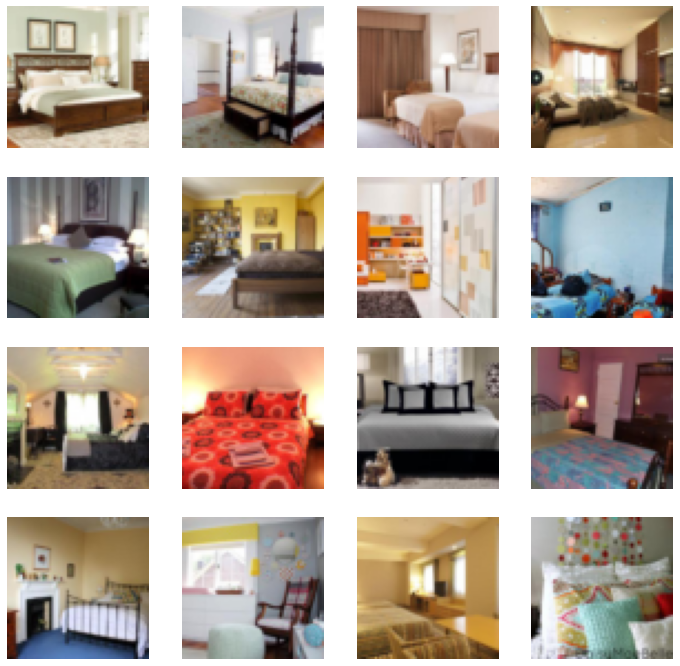

In [ ]:
dls.show_batch(max_n=16)

## GAN Learner

In [ ]:
#export
def gan_loss_from_func(loss_gen, loss_crit, weights_gen=None):
    "Define loss functions for a GAN from `loss_gen` and `loss_crit`."
    def _loss_G(fake_pred, output, target, weights_gen=weights_gen):
        ones = fake_pred.new_ones(fake_pred.shape[0])
        weights_gen = ifnone(weights_gen, (1.,1.))
        return weights_gen[0] * loss_crit(fake_pred, ones) + weights_gen[1] * loss_gen(output, target)

    def _loss_C(real_pred, fake_pred):
        ones  = real_pred.new_ones (real_pred.shape[0])
        zeros = fake_pred.new_zeros(fake_pred.shape[0])
        return (loss_crit(real_pred, ones) + loss_crit(fake_pred, zeros)) / 2

    return _loss_G, _loss_C

In [ ]:
#export
def _tk_mean(fake_pred, output, target): return fake_pred.mean()
def _tk_diff(real_pred, fake_pred): return real_pred.mean() - fake_pred.mean()

In [ ]:
#export
@delegates()
class GANLearner(Learner):
    "A `Learner` suitable for GANs."
    def __init__(self, dls, generator, critic, gen_loss_func, crit_loss_func, switcher=None, gen_first=False,
                 switch_eval=True, show_img=True, clip=None, cbs=None, metrics=None, **kwargs):
        gan = GANModule(generator, critic)
        loss_func = GANLoss(gen_loss_func, crit_loss_func, gan)
        if switcher is None: switcher = FixedGANSwitcher(n_crit=5, n_gen=1)
        trainer = GANTrainer(clip=clip, switch_eval=switch_eval, gen_first=gen_first, show_img=show_img)
        cbs = L(cbs) + L(trainer, switcher)
        metrics = L(metrics) + L(*LossMetrics('gen_loss,crit_loss'))
        super().__init__(dls, gan, loss_func=loss_func, cbs=cbs, metrics=metrics, **kwargs)

    @classmethod
    def from_learners(cls, gen_learn, crit_learn, switcher=None, weights_gen=None, **kwargs):
        "Create a GAN from `learn_gen` and `learn_crit`."
        losses = gan_loss_from_func(gen_learn.loss_func, crit_learn.loss_func, weights_gen=weights_gen)
        return cls(gen_learn.dls, gen_learn.model, crit_learn.model, *losses, switcher=switcher, **kwargs)

    @classmethod
    def wgan(cls, dls, generator, critic, switcher=None, clip=0.01, switch_eval=False, **kwargs):
        "Create a WGAN from `data`, `generator` and `critic`."
        return cls(dls, generator, critic, _tk_mean, _tk_diff, switcher=switcher, clip=clip, switch_eval=switch_eval, **kwargs)

GANLearner.from_learners = delegates(to=GANLearner.__init__)(GANLearner.from_learners)
GANLearner.wgan = delegates(to=GANLearner.__init__)(GANLearner.wgan)

In [ ]:
from fastai2.callback.all import *

In [ ]:
generator = basic_generator(64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (64, n_channels=3, n_extra_layers=1, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))

In [ ]:
learn = GANLearner.wgan(dls, generator, critic, opt_func = RMSProp)

In [ ]:
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [ ]:
#slow
learn.fit(1, 2e-4, wd=0.)

epoch,train_loss,gen_loss,crit_loss,time
0,-0.853155,0.642685,-1.197410,13:08


/usr/local/lib/python3.6/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


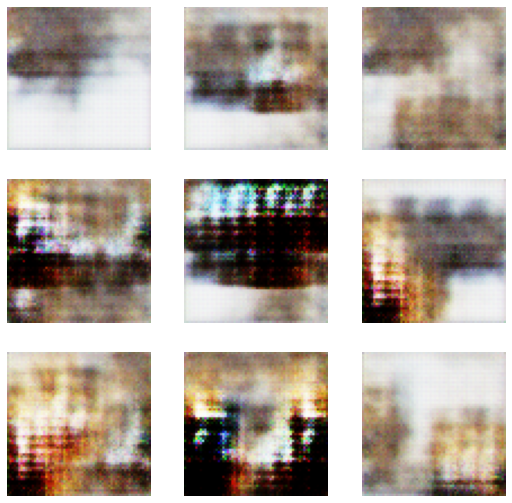

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 18a_callback.training.ipynb.
Converted 19_callback.mixup.ipynb.
Converted 20_interpret.ipynb.
Converted 20a_distributed.ipynb.
Converted 21_vision.l